In [1]:
#!pip install -q wot

# Estimate cell growth rates
Before computing transport maps, we first form an initial estimate of the cell growth rate function $g(x)$. We do this using signatures of proliferation and apoptosis computed in Notebook 1. 
Examining the histograms of these signatures reveals a bimodal distribution in proliferation rates.

In [ ]:
# load proliferation and apoptosis scores

proliferation=modules$Cell.cycle
apoptosis = modules$Apoptosis

# plot histogram of proliferation and apoptosis

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

n_bins = 10
axs[0].hist(proliferation, bins=n_bins)
axs[1].hist(apoptosis, bins=n_bins)

We apply a logistic function to transform these two peaks into biologically plausible vaules, in terms of  where the most proliferative cells double every 9 hours, and the least proliferative cells double every 60 hours. 

In [ ]:
# apply logistic function to transform to birth rate and death rate


logistic<-function(x,L=1,k=1,x0=0){
  f = L/(1+exp(-k*(x-x0)))
  return(f)  
}

genLogistic<-function(p,betaMax,betaMin,pmax,pmin,center,width){
  return(betaMin+logistic(p,L=betaMax-betaMin,k=4/width,x0=center))
}

beta<-function(p,betaMax = 1.7,betaMin=0.4,pmax=1.0,pmin=-0.5,center=0.25){
  # map proliferation p into interval betaMax, betaMin
  return(genLogistic(p,betaMax,betaMin,pmax,pmin,center,width=0.5))
}
delta<-function(a,deltaMax=1.7,deltaMin=0.15,amax=0.5,amin=-0.4,center=0.1){
  return(genLogistic(a,deltaMax,deltaMin,amax,amin,center,width=0.2))
}

birth = beta(proliferation)
death = delta(apoptosis)

# growth rate is given by 
# g = exp(birth - death)

gr = exp(birth-death)
growth = cbind(cell_IDs,gr)
growth_null = growth
growth_null[,2] = gr*0+1
write.table(growth,"/Users/geoff/wot/V2_growth.txt",sep="\t",col.names=F,row.names=F,quote=F)


# Load data for computing transport maps

We now read in the expression matrix, cell days, initial cell growth rates. 
We apply a filter to compute transport maps for the serum time course. (Recall that the dataset includes two time-courses: 2i and serum). 

In [1]:
import wot
import matplotlib.pyplot as plt

VAR_GENE_DS_PATH = 'data/ExprMatrix.var.genes.loom'
GROWTH_SCORES_PATH = 'data/growth_gs_init.txt'
CELL_DAYS_PATH = 'data/cell_days.txt'
SERUM_CELL_IDS_PATH = 'data/serum_cell_ids.txt'

adata = wot.io.read_dataset(VAR_GENE_DS_PATH, obs=[CELL_DAYS_PATH, GROWTH_SCORES_PATH], obs_filter=SERUM_CELL_IDS_PATH)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
adata.shape

(175472, 1479)

# Compute transport maps

Initialize OT model

In [3]:
ot_model = wot.ot.OTModel(adata, growth_iters=3) 

Compute a single transport map from day 7 to 7.5

In [4]:
tmap_adata = ot_model.compute_transport_map(7,7.5)

The object tmap_adata is an annotated transport matrix. 
The actual transport matrix is tmap_adata.X

tmap_adata.obs encodes the cell barcodes at time t0 and tmap_adata.var encodes the cell barcodes at time t1.

In [5]:
tmap_adata.obs

,g0,g1,g2,g3
id,,,,
D7_Dox_C1_AAACCTGAGGAATCGC-1,1.501791,1.146697,0.898082,0.716976
D7_Dox_C1_AAACCTGAGTAGATGT-1,2.989438,2.519022,2.138183,1.831273
D7_Dox_C1_AAACCTGCAACCGCCA-1,1.699754,1.632620,1.551587,1.464757
D7_Dox_C1_AAACCTGCACTATCTT-1,3.079174,2.796191,2.522095,2.269748
D7_Dox_C1_AAACCTGCAGCCTGTG-1,1.014346,0.908840,0.807168,0.713982
D7_Dox_C1_AAACCTGCATATACGC-1,1.245687,1.212256,1.163713,1.107662
D7_Dox_C1_AAACCTGCATCCGTGG-1,1.100886,1.069409,1.025116,0.972374
D7_Dox_C1_AAACCTGTCGGAATCT-1,1.088761,1.155698,1.201569,1.231343
D7_Dox_C1_AAACGGGGTAGTACCT-1,0.416973,0.442949,0.462500,0.476866


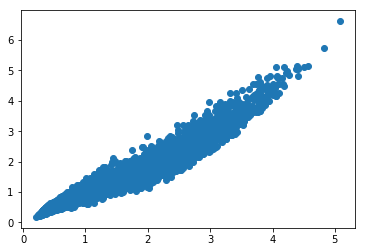

In [6]:
plt.scatter(tmap_adata.obs['g1'],tmap_adata.obs['g2'])
plt.show()

Compute another transport map from day 7.5 to 8

In [ ]:
tmap_adata = ot_model.compute_transport_map(7.5, 8)

Compute all transport maps

In [7]:
ot_model.compute_all_transport_maps(tmap_out='tmaps/serum')